In [102]:
import pandas as pd

df = pd.read_csv('bbc-text.csv', on_bad_lines='skip')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [103]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from textblob import Word

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
STOPWORDS = stopwords.words("english")

In [105]:
def clean(text):
    text = text.lower()
    text = re.sub("[^\w\s]","",text) # Remove punctuations 
    text = " ".join(w for w in text.split() if w not in STOPWORDS)
    text = " ".join([Word(word).lemmatize() for word in text.split()])
    return text

def remove_duplicates(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [106]:
df['text'] = df['text'].apply(lambda x : clean(x)) 
df['text'] = df['text'].apply(lambda x :  remove_duplicates(x))

In [107]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [108]:
# one-hot-endcoding
category = pd.get_dummies(df.category)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='category')
new_df

,text,business,entertainment,politics,sport,tech
0,tv future hand viewer home theatre system plas...,0,0,0,0,1
1,worldcom bos left book alone former worldcom b...,1,0,0,0,0
2,tiger wary farrell gamble leicester say rushed...,0,0,0,1,0
3,yeading face newcastle fa cup premiership side...,0,0,0,1,0
4,ocean twelve raid box office ocean twelve crim...,0,1,0,0,0
...,...,...,...,...,...,...
2220,car pull u retail figure u retail sale fell 03...,1,0,0,0,0
2221,kilroy unveils immigration policy exchatshow h...,0,0,1,0,0
2222,rem announce new glasgow concert u band rem an...,0,1,0,0,0
2223,political squabble snowball become commonplace...,0,0,1,0,0


In [109]:
# Ubah tipe dataframe ke array
text = new_df['text'].values
label = new_df[['tech', 'business', 'sport', 'entertainment', 'politics']].values

In [110]:
# bagi data menjadi train dan test
from sklearn.model_selection import train_test_split
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [111]:
# tokenisasi
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='-')
tokenizer.fit_on_texts(text_train) 

print(tokenizer.word_index)

{'-': 1, 'said': 2, 'mr': 3, 'year': 4, 'would': 5, 'also': 6, 'people': 7, 'new': 8, 'u': 9, 'one': 10, 'could': 11, 'game': 12, 'time': 13, 'last': 14, 'first': 15, 'say': 16, 'world': 17, 'government': 18, 'two': 19, 'company': 20, 'make': 21, 'film': 22, 'uk': 23, 'firm': 24, 'get': 25, 'told': 26, 'best': 27, 'take': 28, 'number': 29, 'made': 30, 'service': 31, 'like': 32, 'month': 33, 'player': 34, 'way': 35, '00': 36, 'many': 37, 'back': 38, 'next': 39, 'market': 40, 'country': 41, 'set': 42, 'week': 43, 'party': 44, 'show': 45, 'bbc': 46, 'three': 47, 'labour': 48, 'sale': 49, 'minister': 50, 'added': 51, 'home': 52, 'want': 53, 'music': 54, 'work': 55, 'well': 56, 'right': 57, 'million': 58, 'may': 59, 'day': 60, 'win': 61, 'good': 62, 'go': 63, 'plan': 64, '2004': 65, 'election': 66, 'group': 67, 'england': 68, 'technology': 69, 'still': 70, 'part': 71, 'play': 72, 'come': 73, 'think': 74, 'going': 75, 'since': 76, 'second': 77, 'much': 78, 'need': 79, 'see': 80, 'use': 81, '

In [145]:
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

# padded_train = pad_sequences(sequences_train)
# padded_test = pad_sequences(sequences_test)
 
padded_train = pad_sequences(sequences_train,
    padding='post',
    maxlen=100,
    truncating='post'
) 
padded_test = pad_sequences(
    sequences_test,
     padding='post',
    maxlen=100,
    truncating='post'
)

In [146]:
# Buat model
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 16)          80000     
                                                                 
 lstm_11 (LSTM)              (None, 64)                20736     
                                                                 
 dense_35 (Dense)            (None, 128)               8320      
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 5)                 325       
                                                                 
Total params: 117,637
Trainable params: 117,637
Non-trainable params: 0
_________________________________________________________________


In [147]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nAkurasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [148]:
history = model.fit(
    padded_train,
    label_train,
    validation_data=(padded_test, label_test),
    epochs=30,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/30
56/56 - 8s - loss: 1.4663 - accuracy: 0.3410 - val_loss: 1.0736 - val_accuracy: 0.4360 - 8s/epoch - 134ms/step
Epoch 2/30
56/56 - 4s - loss: 0.9003 - accuracy: 0.6337 - val_loss: 0.7131 - val_accuracy: 0.7056 - 4s/epoch - 64ms/step
Epoch 3/30
56/56 - 4s - loss: 0.4702 - accuracy: 0.8275 - val_loss: 0.4880 - val_accuracy: 0.8022 - 4s/epoch - 64ms/step
Epoch 4/30

Akurasi telah mencapai >95%!
56/56 - 4s - loss: 0.1810 - accuracy: 0.9534 - val_loss: 0.5096 - val_accuracy: 0.8539 - 4s/epoch - 64ms/step


In [149]:
import matplotlib.pyplot as plt

# evaluasi performa model yang telah dibuat
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

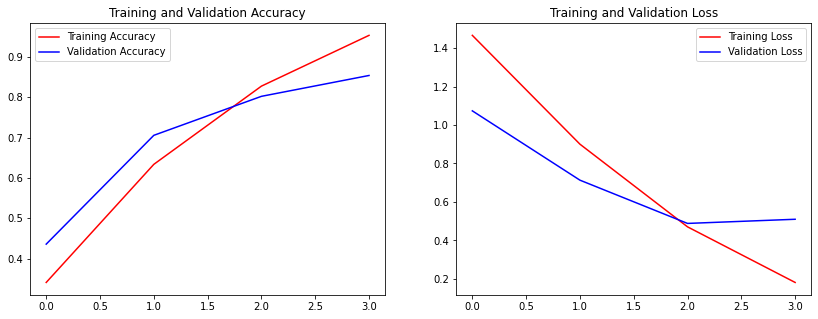

In [150]:
eval_plot(history)